# 1 Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import inflection

# 2. Data Exploration

In [5]:
data = pd.read_csv('../data/fraud_0.1origbase.csv')

In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [7]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,242.931935,1.800585e+05,8.317937e+05,8.528354e+05,1.096212e+06,1.221809e+06,0.001290,0.000003
std,142.330857,6.069714e+05,2.885636e+06,2.921296e+06,3.375389e+06,3.656213e+06,0.035898,0.001773
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,155.000000,1.340742e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,238.000000,7.481577e+04,1.423900e+04,0.000000e+00,1.315397e+05,2.147127e+05,0.000000,0.000000
75%,334.000000,2.084988e+05,1.072998e+05,1.435652e+05,9.384820e+05,1.109230e+06,0.000000,0.000000
max,742.000000,5.722962e+07,4.368662e+07,4.367380e+07,3.551855e+08,3.555534e+08,1.000000,1.000000


## 2.1. Column Description

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction

**newbalanceDest:** new balance recipient after the transaction

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [8]:
new_cols = [inflection.underscore(col) for col in data.columns.tolist()]
data.columns = new_cols
data.head()


,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [9]:
print(f'Data shape {data.shape}')


Data shape (636262, 11)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


In [11]:
data.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

In [12]:
# change data type

data['is_fraud'] = data['is_fraud'].map({1: 'yes', 0: 'no'})
data['is_flagged_fraud'] = data['is_flagged_fraud'].map({1: 'yes', 0: 'no'})
data.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,no,no
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,no,no
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,no,no
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,no,no
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,no,no


Text(0.5, 1.0, 'Balance Change (Original Accounts)')

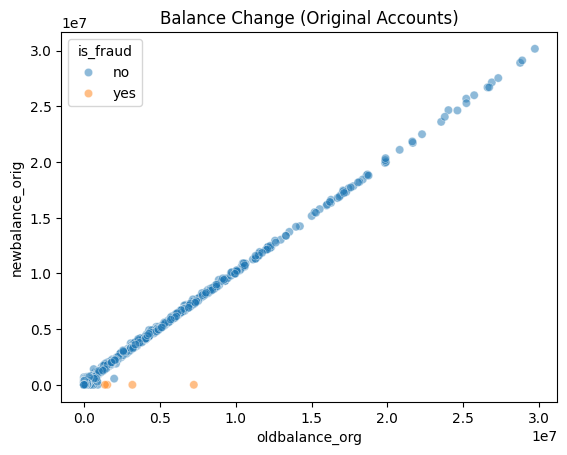

In [13]:
sns.scatterplot(
    data=data.sample(5000), 
    x='oldbalance_org', 
    y='newbalance_orig', 
    hue='is_fraud', 
    alpha=0.5
)
plt.title('Balance Change (Original Accounts)')

Text(0.5, 1.0, 'Transaction Type Distribution')

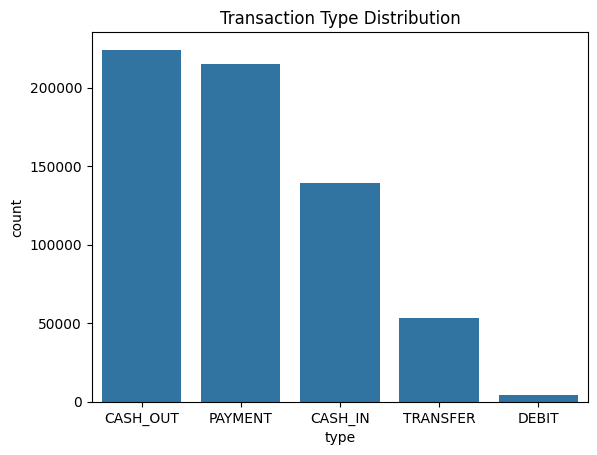

In [14]:
sns.countplot(data=data, x='type', order=data['type'].value_counts().index)
plt.title('Transaction Type Distribution')

Text(0.5, 1.0, 'Fraudulent Ratio')

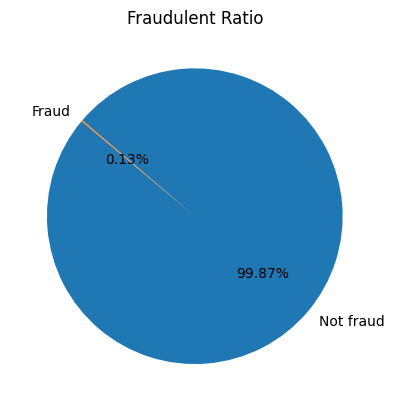

In [15]:
labels = ['Not fraud', 'Fraud']
fraud_counts = data['is_fraud'].value_counts()
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=140)
plt.title('Fraudulent Ratio')


In [16]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include='object')

In [17]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['coefficient of Variation'] = (num_attributes.std() / num_attributes.mean())
describe['skewness'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe



,count,mean,std,min,25%,50%,75%,max,range,coefficient of Variation,skewness,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


In [18]:
cat_attributes.describe()


,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C1785652992,C1023714065,no,no
freq,224216,2,14,635441,636260


# 3. Feature Engineering

In [19]:
df = data.copy()

In [ ]:
df['step_days'] = [step / 24 for step in df['step']]
df['step_weeks'] = [step / 168 for step in df['step']]

df['diff_new_old_orig'] = df['newbalance_orig'] - df['oldbalance_org']

df['diff_new_old_dest'] = df['newbalance_dest'] - df['oldbalance_dest']
